In [64]:
%run -m ipy_startup
%run -m ipy_plotly
%matplotlib inline
from ml.model import models as ml_models
from ml.model import summaries as ml_precis
from ml.model import conditional_dependence, partial_dependence

In [8]:
from sklearn.datasets import load_boston
d = load_boston()
d = pd.DataFrame(d['data'], columns=d['feature_names']).assign(y=d['target'])
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
y          506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [61]:
print(load_boston()['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [9]:
response = 'y'
X, y = d.drop(response, axis=1), d[response]

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
clfs = {
    'rf': RandomForestRegressor()
}
cv = KFold(len(y), 5)
cv_res, refit_res = ml_models.run_regressors(X, y, clfs, cv, refit=True)

Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


In [68]:
feat_imp = ml_models.summarize_importances([refit_res])
ml_precis.plot_feature_importance([refit_res])

In [48]:
clf_name = 'rf'
clf = ml_models.extract_model_results(clf_name, [refit_res])[0]
clf = clf['model']['value']
clf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [76]:
top_feat = feat_imp.select_dtypes(include=[np.float64]).T[0].sort_values(ascending=False).head(8)
top_feat

RM         0.462581
LSTAT      0.346793
DIS        0.067920
CRIM       0.033559
NOX        0.017872
PTRATIO    0.017613
AGE        0.014407
B          0.014355
Name: 0, dtype: float64

In [79]:
pred = lambda clf, X: clf.predict(X)
pdp = partial_dependence.get_partial_dependence_1d(clf, X, top_feat.index.values, pred)

Processing feature 1 of 8 ...
Processing feature 2 of 8 ...
Processing feature 3 of 8 ...
Processing feature 4 of 8 ...
Processing feature 5 of 8 ...
Processing feature 6 of 8 ...
Processing feature 7 of 8 ...
Processing feature 8 of 8 ...


In [92]:
partial_dependence.plot_partial_dependence(pdp, n_cols=4, sharey=True)

In [100]:
imp.reload(conditional_dependence)

<module 'ml.model.conditional_dependence' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/model/conditional_dependence.py'>

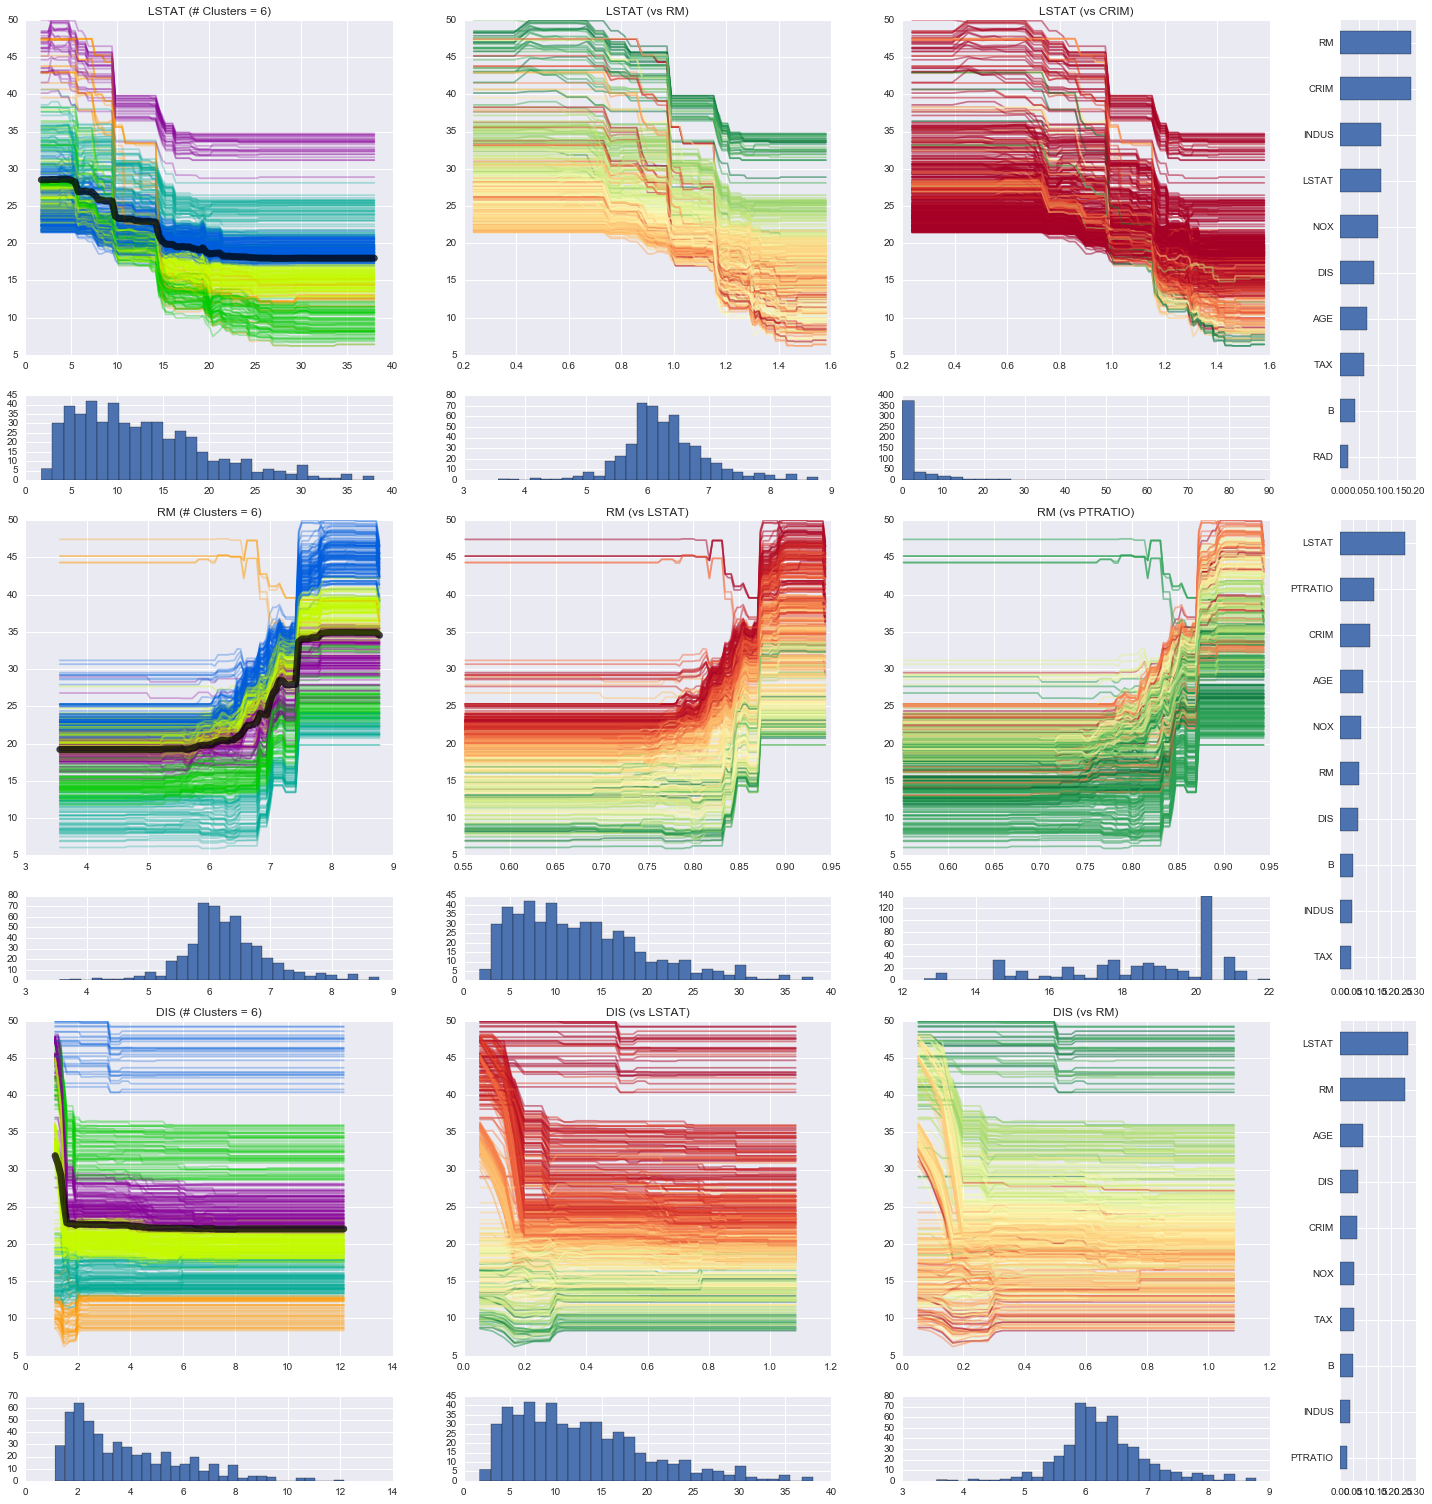

In [101]:
from sklearn.cluster import KMeans
ice = {k:v for k, v in pdp.items() if k in top_feat.head(3).index}
conditional_dependence.plot_ice(X, ice, random_state=1, n_sample=len(X), cluster_alg=KMeans, n_interaction=2)